In [1]:
import time

import numpy as np
import scipy.stats as stats
import dask.array as da

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import sklearn

import dask_ml
from dask_ml.datasets import make_classification
from dask_ml.wrappers import Incremental
from dask_searchcv import Hyperband
import dask_searchcv
dask_searchcv.__file__

'/Users/ssievert/Developer/stsievert/dask-searchcv/dask_searchcv/__init__.py'

In [7]:
n, d = int(1000), int(100)
X, y = make_classification(n_features=d, n_samples=n,
                           chunks=(n//10, d))
classes = da.unique(y)

kwargs = dict(loss='hinge', penalty='elasticnet',
              max_iter=1.0, warm_start=True)
model = Incremental(SGDClassifier(), **kwargs)
params = {'alpha': np.logspace(-4, 0, num=1000),
          'l1_ratio': stats.uniform(0, 1),
          'average': [True, False]}

# class ConstantFunction:
#     def _fn(self):
#         return self.value

#     def get_params(self, deep=None, **kwargs):
#         return {k: getattr(self, k) for k, v in kwargs.items()}

#     def set_params(self, **kwargs):
#         for k, v in kwargs.items():
#             setattr(self, k, v)
#         return self

#     def partial_fit(self, *args, **kwargs):
#         pass

#     def score(self, *args, **kwargs):
#         return self._fn()
    
#     def fit(self, *args, **kwargs):
#         return self._fn()
    
# model = ConstantFunction()
# params = {'value': stats.uniform(0, 1)}

In [8]:
from distributed import Client
client = Client()

In [9]:
alg = Hyperband(model, params, max_iter=9)

alg.fit(X, y, classes=classes)

distributed.utils - ERROR - '<' not supported between instances of 'NoneType' and 'NoneType'
Traceback (most recent call last):
  File "/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/distributed/bokeh/scheduler.py", line 1107, in graph_doc
    graph = GraphPlot(scheduler, sizing_mode='stretch_both')
  File "/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/distributed/bokeh/scheduler.py", line 612, in __init__
    self.layout = GraphLayout(scheduler)
  File "/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/distributed/diagnostics/graph_layout.py", line 37, in __init__
    priority=priority)
  File "/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/distributed/diagnostics/graph_layout.py", line 41, in update_graph
    stack = sorted(dependencies, key=priority.get, re

Hyperband(eta=3, max_iter=None,
     model=Incremental(SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1.0, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=True)),
     n_jobs=-1, param_distributions=None, scoring=None)

In [8]:
import pandas as pd
df = pd.DataFrame(alg.history)
print(df.bracket.max())
print(df.bracket_iter.unique())
df.tail()

3
[0 1 2]


,bracket,bracket_iter,model_id,num_models,param_value,partial_fit_iters,val_score
62,1,1,s=1-3,2,0.764897,36.0,0.764897
63,0,0,s=0-0,4,0.991038,27.0,0.991038
64,0,0,s=0-1,4,0.670388,27.0,0.670388
65,0,0,s=0-2,4,0.949570,27.0,0.949570
66,0,0,s=0-3,4,0.499825,27.0,0.499825


In [9]:
results = pd.DataFrame(alg.cv_results_)
results.head()

,param_value,params,fit_time,score_time,test_score
0,0.262423,{'value': 0.2624227070693479},0.000017,0.000005,0.262423
1,0.838458,{'value': 0.8384575353122933},0.000033,0.000014,0.838458
2,0.333099,{'value': 0.33309898332376264},0.000012,0.000004,0.333099
3,0.887817,{'value': 0.8878169382212592},0.000026,0.000007,0.887817
4,0.990135,{'value': 0.9901346767185802},0.000048,0.000010,0.990135


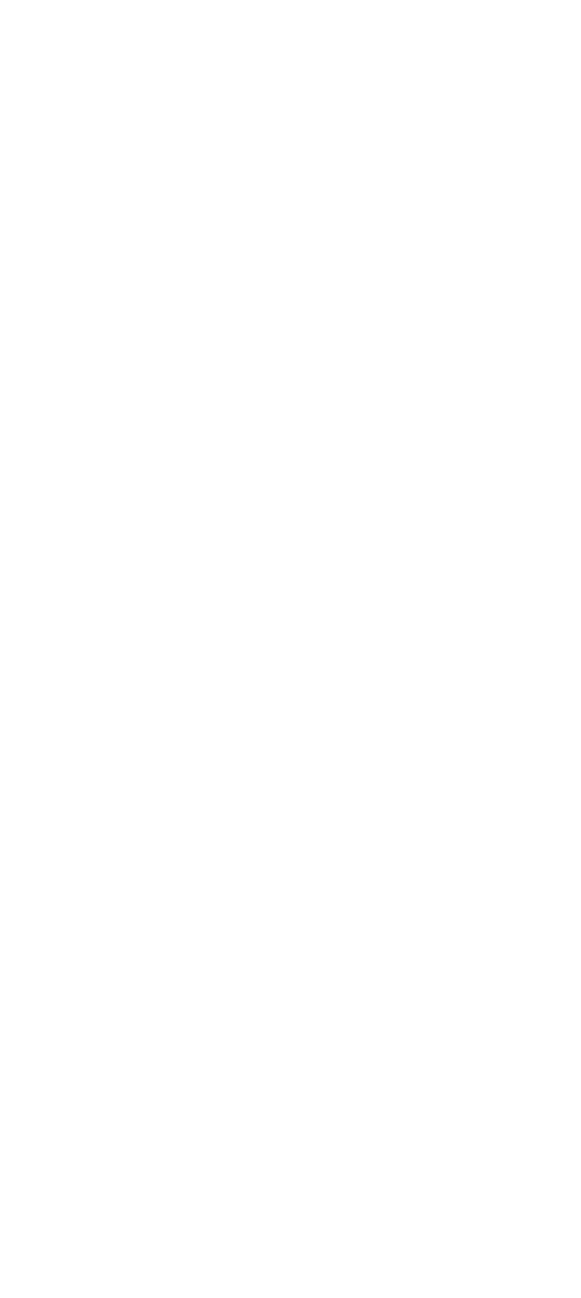

In [10]:
import altair as alt
import matplotlib.pyplot as plt

# different brackets; need a better name than "s"
df['-bracket'] = -1 * df['bracket']

alt.Chart(df).mark_line().encode(
    x='bracket_iter', 
    y=alt.Y('val_score', scale=alt.Scale(zero=False)),
    color='model_id',
    row='-bracket')